In [1]:
import numpy as np

import skimage as sk
import skimage.io as skio
import skimage.data as data
import skimage.transform as sktr
from skimage.draw import polygon
from skimage.feature import corner_harris, peak_local_max
from skimage.color import rgb2gray
from scipy.spatial import Delaunay

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_points(im, num_pts):
    print('Please select {} points in each image for alignment.'.format(num_pts))
    plt.imshow(im)
    pts = np.array(plt.ginput(num_pts, timeout=0))
    plt.close()
    return pts

def computeH(pts, pts1):
    # comput the homography mapping pts to pts1
    p_list = [pts[i, :] for i in range(pts.shape[0])]
    p1_list = [pts1[i, :] for i in range(pts1.shape[0])]
    A = np.vstack([
            np.array([[p[0], p[1], 1, 0, 0, 0, -p[0]*p1[0], -p[1]*p1[0]],
                      [0, 0, 0, p[0], p[1], 1, -p[0]*p1[1], -p[1]*p1[1]]]) 
                  for p, p1 in zip(p_list, p1_list)])
    b = pts1.flatten()
    h, _, _, _ = np.linalg.lstsq(A, b)
    H = np.append(h, 1).reshape((3, 3))
    return H

def warpImage(im, im_base, H, H1):
    corners = np.array([[0, 0],
               [0, im.shape[1]-1],
               [im.shape[0]-1, im.shape[1]-1],
               [im.shape[0]-1, 0]]).T
    corners = np.vstack([corners, np.ones((1, 4))])
    warped_corners = np.dot(H, corners)
    warped_corners = warped_corners / warped_corners[2, :]
    print(warped_corners)
    
    
    minx = np.min(np.floor(warped_corners[0])).astype(int)
    maxx = np.max(np.ceil(warped_corners[0])).astype(int)
    miny = np.min(np.floor(warped_corners[1])).astype(int)
    maxy = np.max(np.ceil(warped_corners[1])).astype(int)
    
    extend_nx = min(minx, 0)
    extend_ny = min(miny, 0)
    print('extend x: ', extend_nx, 'extend y: ', extend_ny)
    mask = np.zeros((max(maxx, im_base.shape[0])-extend_nx, 
                     max(maxy, im_base.shape[1])-extend_ny, 3))
    
    rr_mask, cc_mask = polygon(warped_corners[0]-extend_nx, warped_corners[1]-extend_ny)
#     rr, cc = polygon(warped_corners[0], warped_corners[1])
    coords = np.array([rr_mask+extend_nx, cc_mask+extend_ny])
#     rr_mask = rr - extend_nx
#     cc_mask = cc - extend_ny
    
    src_pts = np.dot(H1, np.vstack([coords, np.ones((1, coords.shape[1]))]))
    src_pts = src_pts / src_pts[2, :]

#     mask[rr_mask, cc_mask] = im[src_pts[0].astype(int), src_pts[1].astype(int)] 
#     print(src_pts.shape[1])
    for i in range(src_pts.shape[1]):
        if i % 1000000 == 0:
            print(i//1000000, "total: ", src_pts.shape[1]//1000000)
        xy = src_pts[[0,1], i].astype(int)
#         print(xy)
        if (0 <= xy[0] < im.shape[0]) and (0 <= xy[1] < im.shape[1]):
            mask[rr_mask[i], cc_mask[i]] = im[xy[0], xy[1]] 
#             mask[rr[i], cc[i]] = im[xy[0], xy[1]] 


            
    return mask, (extend_nx, extend_ny)

## Image Rectification

In [269]:
#  ____>y
# |
# |
# v
# x
im_base = plt.imread('1.3.jpeg')
im1 = plt.imread('1.4.jpeg')
im2 = im_base

im_base = plt.imread('roof00.jpeg')
im1 = plt.imread('roof01.jpeg')
im2 = im_base

In [270]:
%matplotlib qt
pts_base = get_points(im_base, 4)
pts1 = get_points(im1, 4)
pts_base = np.roll(pts_base, 1, axis=1)
pts1 = np.roll(pts1, 1, axis=1)

Please select 4 points in each image for alignment.
Please select 4 points in each image for alignment.


In [271]:
%matplotlib inline
H1 = computeH(pts_base, pts1)
H = computeH(pts1, pts_base)

/Users/cxx/opt/anaconda3/envs/cs194/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [272]:
warped_img, extend = warpImage(im1, im_base, H, H1)
warped_img = warped_img.astype(int)

[[ 1.77443715e+02 -1.26822610e+03  4.05555315e+03  2.68709692e+03]
 [ 1.74287727e+03  7.84791840e+03  7.80680351e+03  1.79492296e+03]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]
extend x:  -1269 extend y:  0
0 total:  23
1 total:  23
2 total:  23
3 total:  23
4 total:  23
5 total:  23
6 total:  23
7 total:  23
8 total:  23
9 total:  23
10 total:  23
11 total:  23
12 total:  23
13 total:  23
14 total:  23
15 total:  23
16 total:  23
17 total:  23
18 total:  23
19 total:  23
20 total:  23
21 total:  23
22 total:  23
23 total:  23


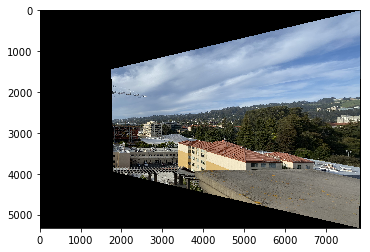

In [273]:
plt.imshow(warped_img)

##  IMAGE WARPING and MOSAICING

In [104]:
# im_base = plt.imread('1.1.jpeg')
# im1 = plt.imread('1.2.jpeg')

prefix = "campus"
im1 = plt.imread(prefix + "0.jpeg")
im_base = plt.imread(prefix + "1.jpeg")

In [106]:
%matplotlib qt
pts_base = get_points(im_base, 4)
pts1 = get_points(im1, 4)
pts_base = np.roll(pts_base, 1, axis=1)
pts1 = np.roll(pts1, 1, axis=1)

Please select 4 points in each image for alignment.
Please select 4 points in each image for alignment.


In [107]:
%matplotlib inline
mosaic = make_mosaic(im_base, im1, pts_base.T, pts1.T)

/Users/cxx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[ 5.72479715e+01 -5.01922525e+03  6.04058118e+03  2.60170968e+03]
 [ 2.54909572e+03  1.70565881e+04  1.29489504e+04  2.52704774e+03]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]
extend x:  -5020 extend y:  0
0 total:  83
1 total:  83
2 total:  83
3 total:  83
4 total:  83
5 total:  83
6 total:  83
7 total:  83
8 total:  83
9 total:  83
10 total:  83
11 total:  83
12 total:  83
13 total:  83
14 total:  83
15 total:  83
16 total:  83
17 total:  83
18 total:  83
19 total:  83
20 total:  83
21 total:  83
22 total:  83
23 total:  83
24 total:  83
25 total:  83
26 total:  83
27 total:  83
28 total:  83
29 total:  83
30 total:  83
31 total:  83
32 total:  83
33 total:  83
34 total:  83
35 total:  83
36 total:  83
37 total:  83
38 total:  83
39 total:  83
40 total:  83
41 total:  83
42 total:  83
43 total:  83
44 total:  83
45 total:  83
46 total:  83
47 total:  83
48 total:  83
49 total:  83
50 total:  83
51 total:  83
52 total:  83
53 total:  83
54 total:  83
55 total

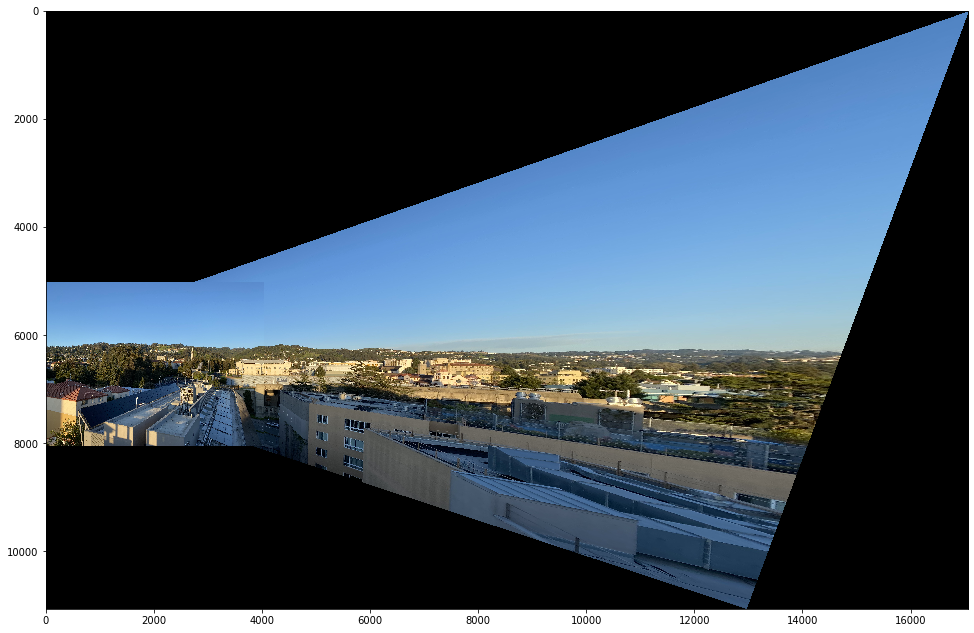

In [108]:
plt.figure(figsize=(mosaic.shape[1]//1000, mosaic.shape[0]//1000))
plt.imshow(mosaic)
plt.savefig(prefix + ".hand.jpg")

## FEATURE MATCHING for AUTOSTITCHING

In [44]:
def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=1, threshold_abs=1, indices=True)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)

def ANMS(h, coords, num):
    nn_table = dist2(coords.T, coords.T)
    sup_rads = np.zeros(coords.shape[1])
    print('done')
    for i in range(coords.shape[1]):
        mask = coords[1, i] < 0.9 * h[coords[0, :], coords[1, :]]
        r_min = np.inf
        for j in range(coords.shape[1]):
            if h[coords[0, i], coords[1, i]] < 0.9 * h[coords[0, j], coords[1, j]]:
                if nn_table[i, j] < r_min:
                    r_min = nn_table[i, j]
        sup_rads[i] = r_min
    sorted_idx = np.flip(np.argsort(sup_rads))
    return coords[:, sorted_idx[:num]]

def show_img_corners(im, coords):
    plt.figure(figsize=(10, 7.5))
    plt.imshow(im)
    plt.scatter(coords[1], coords[0], s=30, c='white', marker='o', linewidth=1.5, edgecolor='black')


def get_patches(im, coords):
    im_bw = rgb2gray(im)

    patches = []
    for i in range(coords.shape[1]):
        x = coords[0, i]
        y = coords[1, i]
        patch = im_bw[x-20:x+20, y-20:y+20]
        patch = sktr.resize(patch, (8, 8))
        mean = np.mean(patch)
        std = np.std(patch)
        patch = (patch - mean) / std
        patches.append(patch)
    
    patches_np = np.dstack(patches)
#     print(patches_np[:,:,0])
    patches_flatten = np.reshape(patches_np, (patches_np.shape[0]*patches_np.shape[1], patches_np.shape[2])).T
#     print(patches_flatten[0])
    return patches_flatten

def match_features(patches1, patches2, coords1, coords2, threshold=0.3):
    nn_table = dist2(patches1, patches2)
    matched_coords1 = []
    matched_coords2 = []
    for i in range(nn_table.shape[0]):
        flat = nn_table[i, :].flatten()
        flat_sort = np.sort(flat)
        flat_sort_idx = np.argsort(flat)
        if flat_sort[1] / flat_sort[2] < threshold:
            matched_coords1.append(coords1[:, i])
            matched_coords2.append(coords2[:, flat_sort_idx[0]])
    matched_coords1 = np.array(matched_coords1).T
    matched_coords2 = np.array(matched_coords2).T
    return matched_coords1, matched_coords2
    print(matched_coords1.shape, matched_coords2.shape)
    
def make_mosaic(im1, im2, final_coords1, final_coords2):
    H = computeH(final_coords1.T, final_coords2.T)
    H1 = computeH(final_coords2.T, final_coords1.T)
    # warped_img, extend = warpImage(im2, im1, H1, H)
    warped_img, extend = warpImage(im1, im2, H, H1)
    warped_img = warped_img.astype(int)
    corners_base = np.array([[0, 0],
                             [0, im2.shape[1]-1],
                             [im2.shape[0]-1, im2.shape[1]-1],
                             [im2.shape[0]-1, 0]]).T
    rr, cc = polygon(corners_base[0], corners_base[1])
    mosaic = warped_img.copy()
    mosaic[rr-extend[0], cc-extend[1]] = im2[rr, cc]
    return mosaic

<>:46: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:46: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:46: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-44-92b521d803ce>:46: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


In [103]:
prefix = "out"
im1 = plt.imread(prefix + "0.jpeg")
im2 = plt.imread(prefix + "1.jpeg")

In [79]:
# Adaptive Non-Maximal Suppression
h1, coords1 = get_harris_corners(rgb2gray(im1))
h2, coords2 = get_harris_corners(rgb2gray(im2))
print(coords1.shape, coords2.shape)

(2, 2831) (2, 6625)


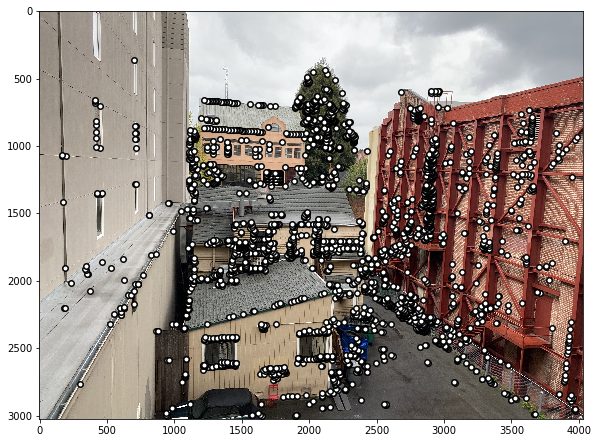

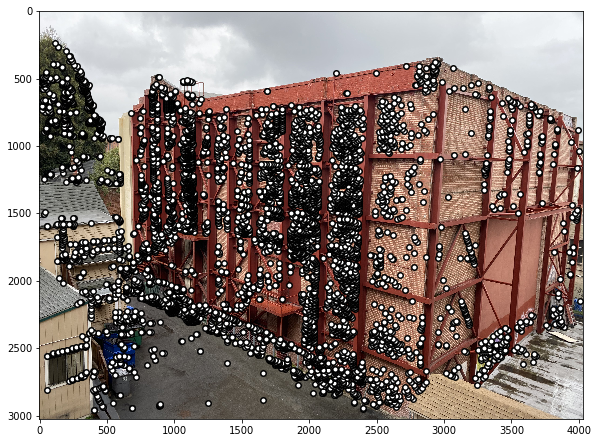

In [80]:
show_img_corners(im1, coords1)
plt.savefig(prefix + ".corners0.jpg")
show_img_corners(im2, coords2)
plt.savefig(prefix + ".corners1.jpg")

In [81]:
coords1_sup = ANMS(h1, coords1, 500)
coords2_sup = ANMS(h2, coords2, 500)

done
done


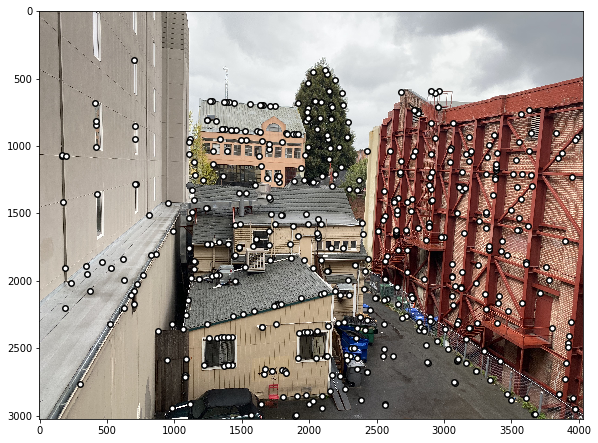

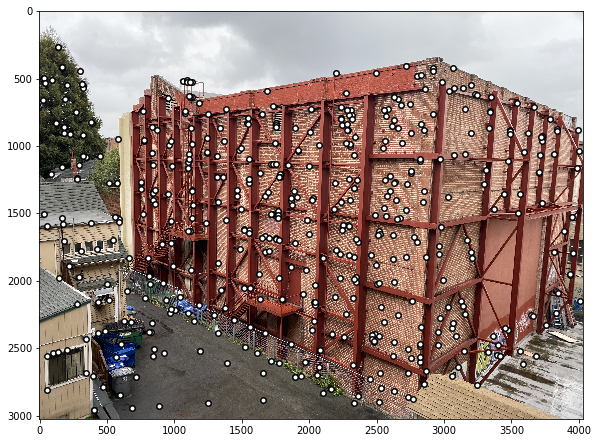

In [82]:
show_img_corners(im1, coords1_sup)
plt.savefig(prefix + ".anms0.jpg")
show_img_corners(im2, coords2_sup)
plt.savefig(prefix + ".anms1.jpg")

In [83]:
# Feature Descriptor extraction
patches1 = get_patches(im1, coords1_sup)
patches2 = get_patches(im2, coords2_sup)
matched_coords1, matched_coords2 = match_features(patches1, patches2, 
                                                  coords1_sup, coords2_sup, threshold=0.7)
print(matched_coords1.shape)

(2, 15)


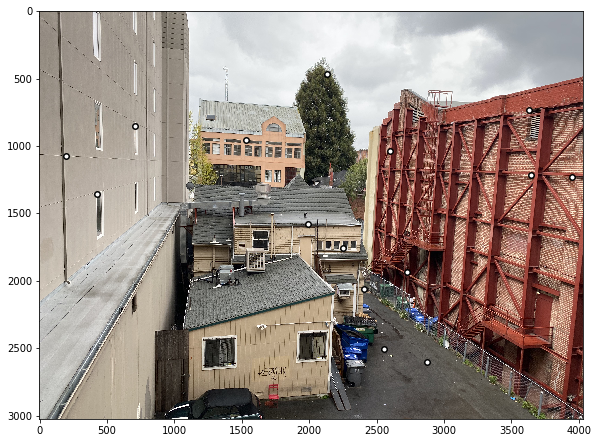

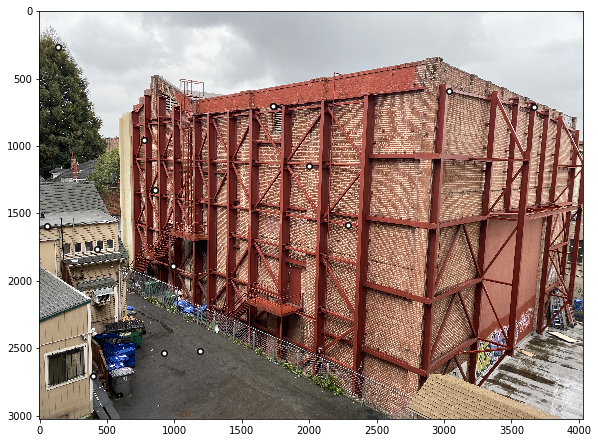

In [84]:
show_img_corners(im1, matched_coords1)
plt.savefig(prefix + ".match0.jpg")
show_img_corners(im2, matched_coords2)
plt.savefig(prefix + ".match1.jpg")

In [85]:
idx_list = []
# inlier_count = np.zeros(matched_coords1.shape[1])
iters = 10000
inlier_count = np.zeros(iters)
for i in range(iters):
    rand_idx = np.random.choice(np.arange(matched_coords1.shape[1]), size=4, replace=False)
    H = computeH(matched_coords1[:, rand_idx].T, matched_coords2[:, rand_idx].T)
    idx_list.append(rand_idx)
    pts1 = np.vstack([matched_coords1, np.ones((1, matched_coords1.shape[1]))])
    warped_pts1 = np.dot(H, pts1)
    warped_pts1 = (warped_pts1 / warped_pts1[2, :])[[0,1]]
    
    err = warped_pts1 - matched_coords2
    sqr_err = np.square(err[0]) + np.square(err[1])
    
    for j in range(sqr_err.shape[0]):
        if sqr_err[j] < 4:
            inlier_count[i] += 1
idx_list = np.array(idx_list)
print(idx_list.shape)

/Users/cxx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(10000, 4)


In [86]:
max_idx = np.argsort(inlier_count)[-1]
idx_set = idx_list[max_idx]
print(idx_set)
# print(idx_set.shape)
final_coords1 = matched_coords1[:, idx_set]
final_coords2 = matched_coords2[:, idx_set]

[ 6  9 12 11]


[[1581 2605  730  464]
 [1988 2877 3634 2134]] [[1594 2520  701  268]
 [  54 1188 1731  138]]


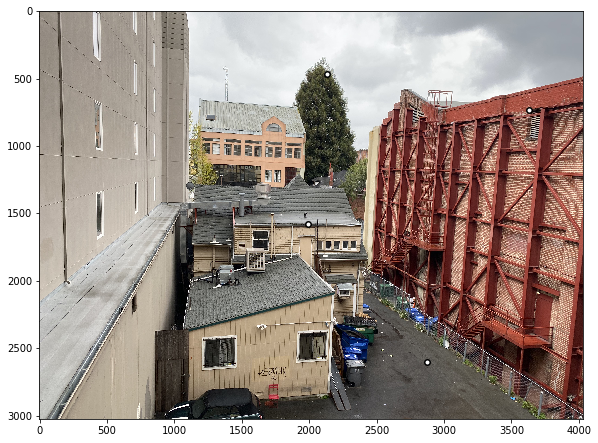

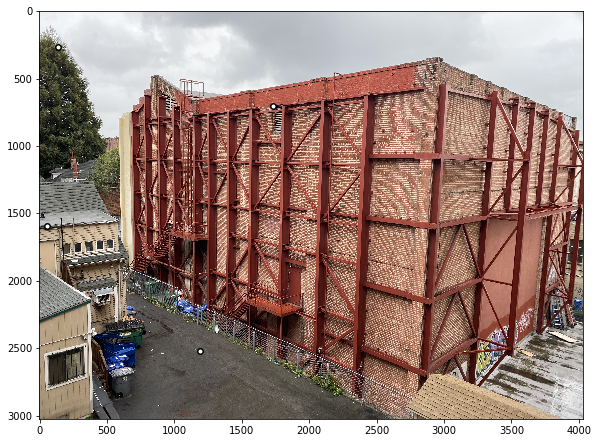

In [87]:
print(final_coords1, final_coords2)
show_img_corners(im1, final_coords1)
plt.savefig(prefix + ".ransac0.jpg")
show_img_corners(im2, final_coords2)
plt.savefig(prefix + ".ransac1.jpg")

In [16]:
%matplotlib inline

In [88]:
# mosaic = make_mosaic(im1, im2, final_coords1, final_coords2)
mosaic = make_mosaic(im2, im1, final_coords2, final_coords1)

/Users/cxx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[ 2.56185463e+02 -1.05443347e+03  5.18158249e+03  2.76732803e+03]
 [ 2.05207102e+03  9.07944238e+03  8.67575165e+03  1.85876284e+03]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]
extend x:  -1055 extend y:  0
0 total:  30
1 total:  30
2 total:  30
3 total:  30
4 total:  30
5 total:  30
6 total:  30
7 total:  30
8 total:  30
9 total:  30
10 total:  30
11 total:  30
12 total:  30
13 total:  30
14 total:  30
15 total:  30
16 total:  30
17 total:  30
18 total:  30
19 total:  30
20 total:  30
21 total:  30
22 total:  30
23 total:  30
24 total:  30
25 total:  30
26 total:  30
27 total:  30
28 total:  30
29 total:  30
30 total:  30


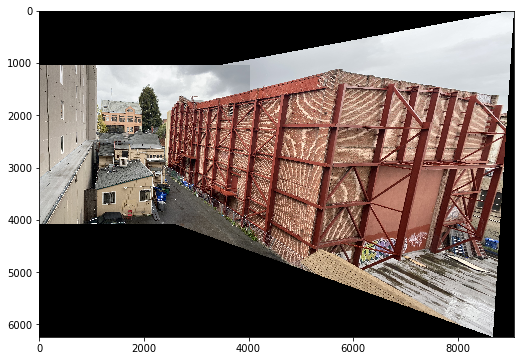

In [89]:
plt.figure(figsize=(mosaic.shape[1]//1000, mosaic.shape[0]//1000))
plt.imshow(mosaic)
plt.savefig(prefix + ".mosaic1.jpg")